In [1]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional  as  F
import math
import numpy as np

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [3]:
from convolve import convolve, nearest_power_of_two
from stu import STU
from lds_utils import compute_ar_x_preds
from lds import LDS

Unable to import FlashFFTConv: No module named 'flashfftconv'. Falling back to PyTorch implementation.


In [8]:
flash_fft_available = False
dtype = torch.bfloat16 if flash_fft_available else torch.float32

use_hankel_L  = False
phi = torch.tensor(np.load('spectral_filters.npy')).to(device).to(dtype)
seq_len, num_eigh = 8192, 24
# phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L, device  = device,  dtype = torch.float32)
n = nearest_power_of_two(seq_len * 2 - 1, round_up=True)

class Config:
    def __init__(self):
        self.num_eigh = num_eigh
        self.use_hankel_L = use_hankel_L
        self.torch_dtype = dtype
        self.n_embd = 1  # d_in and d_out
        self.seq_len = seq_len
        self.k_u = 0
        self.use_flash_fft = flash_fft_available
        self.use_approx = False

stu_config = Config()


In [9]:
import os
import torch
from pathlib import Path


def load_lds_stu_pairs(directory="../../della/lds_trained"):
    # Convert to Path object for easier path manipulation
    dir_path = Path(directory)
    
    # Dictionary to store pairs temporarily
    pairs_dict = {}
    
    # List all files in directory
    for file in dir_path.glob("*"):
        if file.suffix == '.pth':
            # Parse filename
            name = file.stem  # Get filename without extension
            if '_lds_' in name or '_stu_' in name:
                # Extract the number and type (lds/stu)
                prefix = name.split('_lds_')[0] if '_lds_' in name else name.split('_stu_')[0]
                number = name.split('_')[-1]
                model_type = 'lds' if '_lds_' in name else 'stu'
                
                # Create key for matching pairs
                key = (prefix, number)
                
                # Initialize dict entry if not exists
                if key not in pairs_dict:
                    pairs_dict[key] = {'lds': None, 'stu': None}
                
                # Load the model state dict
                model_state = torch.load(file)
                pairs_dict[key][model_type] = model_state
    
    # Convert to list of pairs, only keeping complete pairs
    pairs = []
    for key, models in pairs_dict.items():
        if models['lds'] is not None and models['stu'] is not None:
            pairs.append((models['lds'], models['stu']))
    
    return pairs

# Usage
lds_stu_pairs = load_lds_stu_pairs()

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_82771/4179131590.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(file)


tensor([[-5.3400],
        [-3.2448],
        [-2.3420],
        ...,
        [-8.5186],
        [-5.1156],
        [-1.5478]]) tensor([[-2.0758e+24],
        [ 1.4451e+26],
        [-2.4013e+27],
        ...,
        [-1.6401e+29],
        [-9.9603e+28],
        [-1.7360e+29]])
inf


Pair 0: MSE = 0.000004
Pair 1: MSE = nan
Pair 2: MSE = 232056063205845237760.000000
Pair 3: MSE = nan
Pair 4: MSE = nan
Pair 5: MSE = inf
Pair 6: MSE = nan
Pair 7: MSE = 709761690932236383643558988975439872.000000
Pair 8: MSE = 208921.843750
Pair 9: MSE = 2052888201265152.000000

Average MSE across all pairs: nan


ValueError: supplied range of [7.089170916962928e-11, inf] is not finite

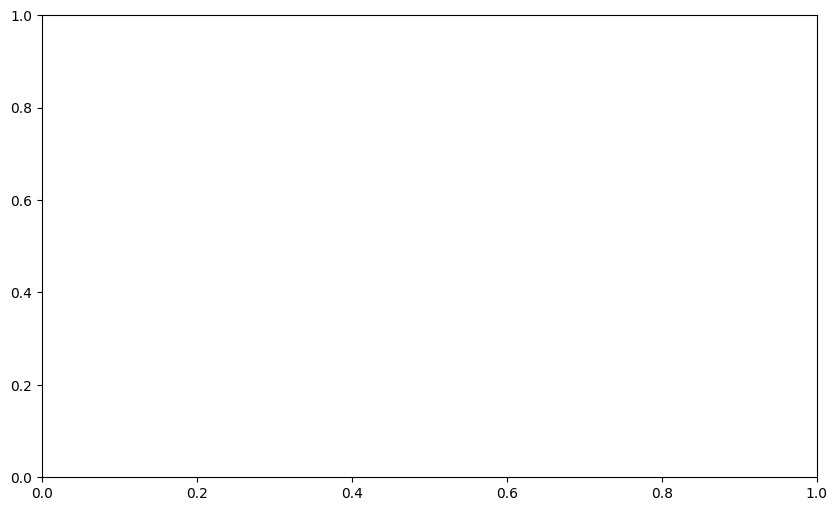

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define a function to compute MSE between LDS and STU outputs
def compute_mse_for_pairs(pairs, seq_len=100, batch_size=1, input_dim=1):
    results = []
    
    for i, (lds, stu) in enumerate(pairs):
        # Generate Gaussian input
        gaussian_input = torch.randn(batch_size, seq_len, input_dim)
        
        # Set models to evaluation mode
        lds.eval()
        stu.eval()
        
        # Forward pass through both models
        with torch.no_grad():
            lds_output = lds(gaussian_input)
            stu_output = stu(gaussian_input)
            
            # Compute MSE
            mse = F.mse_loss(lds_output, stu_output).item()
            
        results.append({
            'pair_index': i,
            'mse': mse,
            'lds': lds,
            'stu': stu
        })
        
    return results

# Compute MSE for all pairs
mse_results = compute_mse_for_pairs(lds_stu_pairs)



Total pairs: 6105
Filtered pairs with MSE < 1e-5: 488


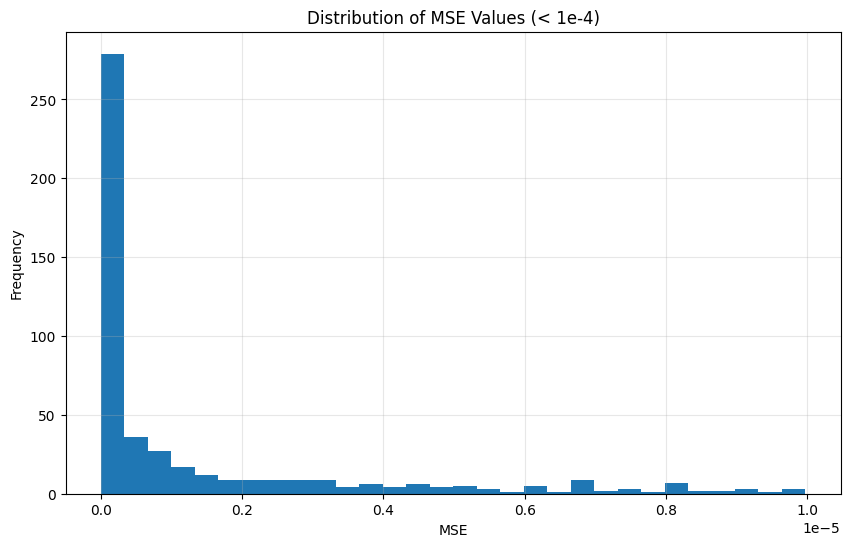

In [27]:
# Filter pairs with MSE less than 1e-4
filtered_pairs = []
for result in mse_results:
    if result['mse'] < 1e-5:
        filtered_pairs.append((result['lds'], result['stu']))

print(f"Total pairs: {len(mse_results)}")
print(f"Filtered pairs with MSE < 1e-5: {len(filtered_pairs)}")

# Create a new list of MSE values for the filtered pairs
filtered_mse = [result['mse'] for result in mse_results if result['mse'] < 1e-5]

# Plot histogram of filtered MSE values if there are any
if filtered_mse:
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_mse, bins=30)
    plt.title('Distribution of MSE Values (< 1e-4)')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No pairs with MSE < 1e-5 found.")


In [34]:

def gen_lds_impulse(lds): #need the stu for to add the negative autoregressive component
    lds_impulse = torch.zeros(seq_len)
    for i in range(seq_len):
        a_power = lds.A ** i
        lds_impulse[i] += torch.sum(lds.C[:, 0] * a_power * lds.B[0]).cpu()
    return lds_impulse

phi_n = phi.data.cpu().numpy()

def gen_stu_impulse(stu):
    alt_sign = lambda x: x * np.array([1, -1] * (seq_len//2))
    pos_coef = stu.M_phi_plus.data.cpu().numpy()[:, 0,0]
    neg_coef = stu.M_phi_minus.data.cpu().numpy()[:,0,0]
    impulse = np.sum(phi_n*pos_coef, axis = -1) + alt_sign(np.sum(phi_n*neg_coef, axis = -1))
    return impulse

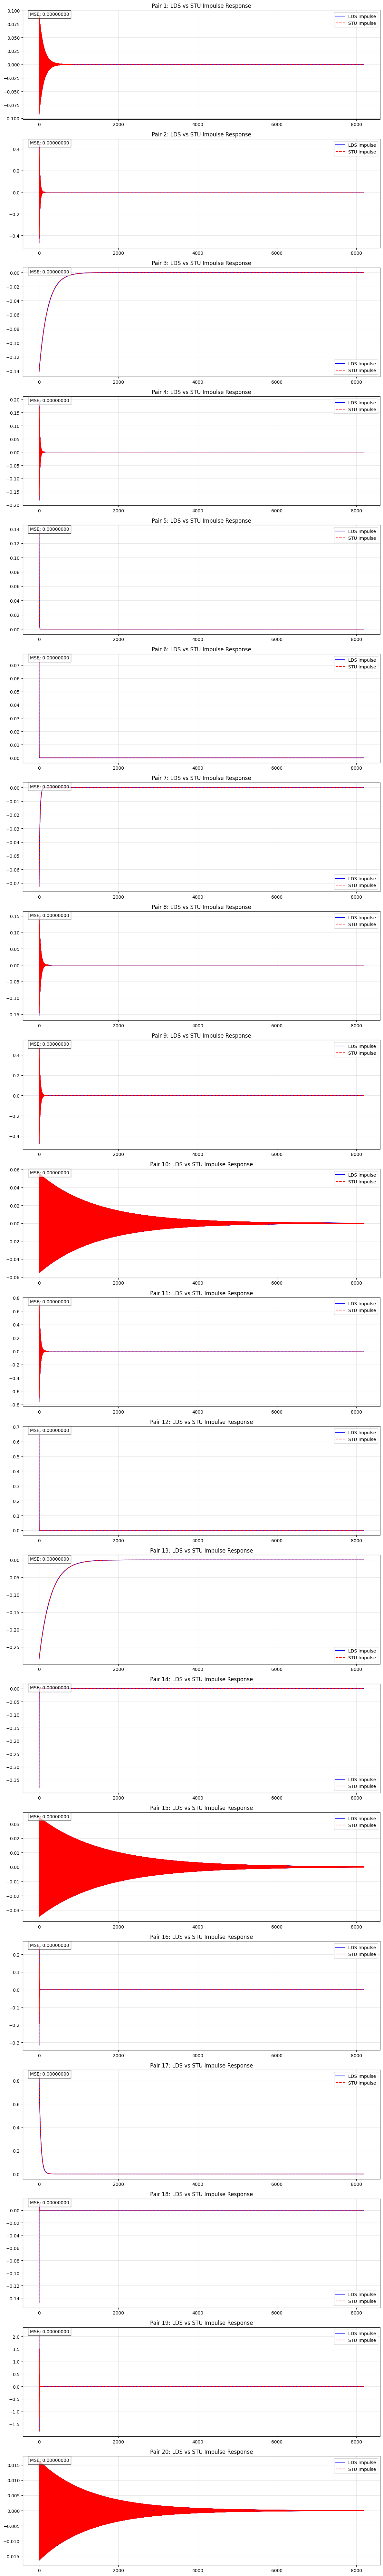

In [36]:
# Sample 20 random pairs from the filtered pairs
import random
import numpy as np
import matplotlib.pyplot as plt

# Make sure we have pairs to sample
if filtered_pairs:
    # Sample min(20, available pairs) to avoid error if we have fewer than 20 pairs
    sample_size = min(20, len(filtered_pairs))
    sampled_pairs = random.sample(filtered_pairs, sample_size)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(sample_size, 1, figsize=(12, 4*sample_size))
    
    # If only one pair is sampled, axes won't be an array
    if sample_size == 1:
        axes = [axes]
    
    # Plot each sampled pair
    for i, (lds, stu) in enumerate(sampled_pairs):
        # Generate impulse responses
        lds_impulse = gen_lds_impulse(lds)
        stu_impulse = gen_stu_impulse(stu)
        
        # Convert to numpy for plotting if needed
        if isinstance(lds_impulse, torch.Tensor):
            lds_impulse = lds_impulse.detach().numpy()
        
        # Plot on the corresponding subplot
        axes[i].plot(lds_impulse, label='LDS Impulse', color='blue')
        axes[i].plot(stu_impulse, label='STU Impulse', color='red', linestyle='--')
        axes[i].set_title(f'Pair {i+1}: LDS vs STU Impulse Response')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Calculate MSE for this pair
        mse = np.mean((lds_impulse - stu_impulse)**2)
        axes[i].text(0.02, 0.95, f'MSE: {mse:.8f}', transform=axes[i].transAxes, 
                     bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
else:
    print("No filtered pairs available to sample.")


In [39]:
# Reconstruct filters from LDS-STU pairs using pseudoinverse approach
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


print(f"Attempting to reconstruct filters from {len(filtered_pairs)} LDS-STU pairs")

# Extract LDS and STU parameters from filtered pairs
lds_params = [lds for lds, _ in filtered_pairs]
stu_params = [stu for _, stu in filtered_pairs]

# Generate impulse responses for all pairs
lds_impulses = np.array([gen_lds_impulse(lds).detach() for lds in lds_params])
stu_impulses = np.array([gen_stu_impulse(stu)for stu in stu_params])

# Convert to torch tensors
lds_impulses_tensor = torch.tensor(lds_impulses, dtype=torch.float)

# Assuming we have the combined weights from the STU parameters
# We'll construct combined_weights from STU parameters


Attempting to reconstruct filters from 488 LDS-STU pairs


TypeError: loop of ufunc does not support argument 0 of type STU which has no callable conjugate method

In [62]:
alternating_signs = np.array([1, -1] * (seq_len//2))
phi_n_alternating = phi_n * alternating_signs[:, np.newaxis]
phi_n_combined = np.concatenate([phi_n, phi_n_alternating], axis=1)  # Shape: (1024, 40)

In [63]:
# For each STU, combine M_phi_plus and M_phi_minus
combined_weights = []
for stu in stu_params:
    # Get M_phi_plus and M_phi_minus from STU model
    M_phi_plus = stu.M_phi_plus.detach().cpu().numpy()[:,0,0]
    M_phi_minus = stu.M_phi_minus.detach().cpu().numpy()[:,0,0]
    
    # Concatenate the weights
    combined = np.concatenate([M_phi_plus, M_phi_minus], axis=0)
    combined_weights.append(combined)

# Stack all combined weights into a single array
combined_weights = np.stack(combined_weights)
combined_weights.shape

(488, 48)

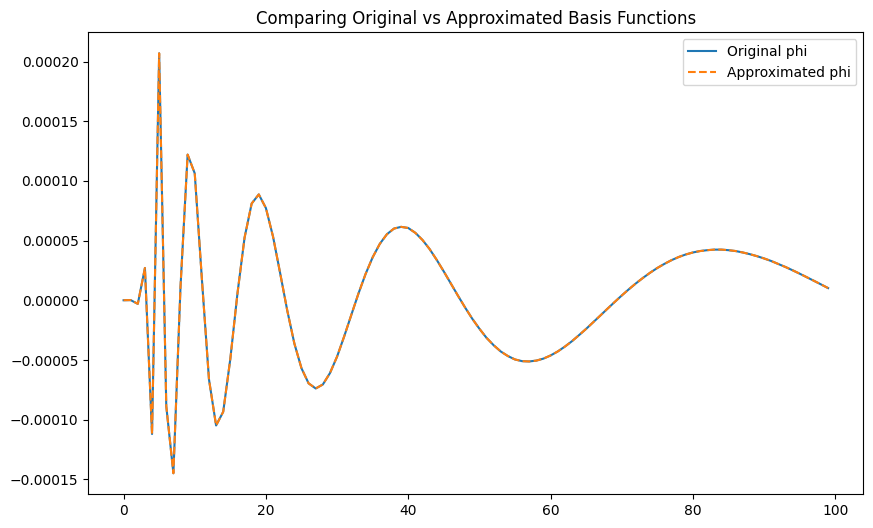

MSE between original and approximated phi: 1.65e-17


In [ ]:
# Use pseudoinverse to solve for phi_n_combined
# reconstructed_filters = phi_n_combined @ combined_weights.T
# Therefore: phi_n_combined = reconstructed_filters @ pinv(combined_weights.T)
combined_weights_pinv = np.linalg.pinv(combined_weights.T)
phi_n_approx = np.matmul(stu_impulses.T, combined_weights_pinv)

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))
print(f"MSE between original and approximated phi: {mse:.2e}")


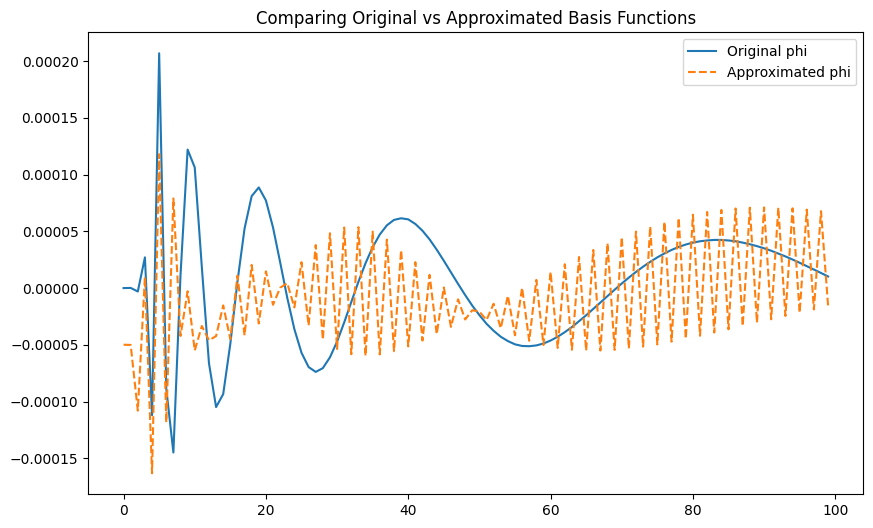

MSE between original and approximated phi: 4.25e-08


In [71]:
# Use pseudoinverse to solve for phi_n_combined
# reconstructed_filters = phi_n_combined @ combined_weights.T
# Therefore: phi_n_combined = reconstructed_filters @ pinv(combined_weights.T)
combined_weights_pinv = np.linalg.pinv(combined_weights.T)
phi_n_approx = np.matmul(lds_impulses.T, combined_weights_pinv)

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))
print(f"MSE between original and approximated phi: {mse:.2e}")


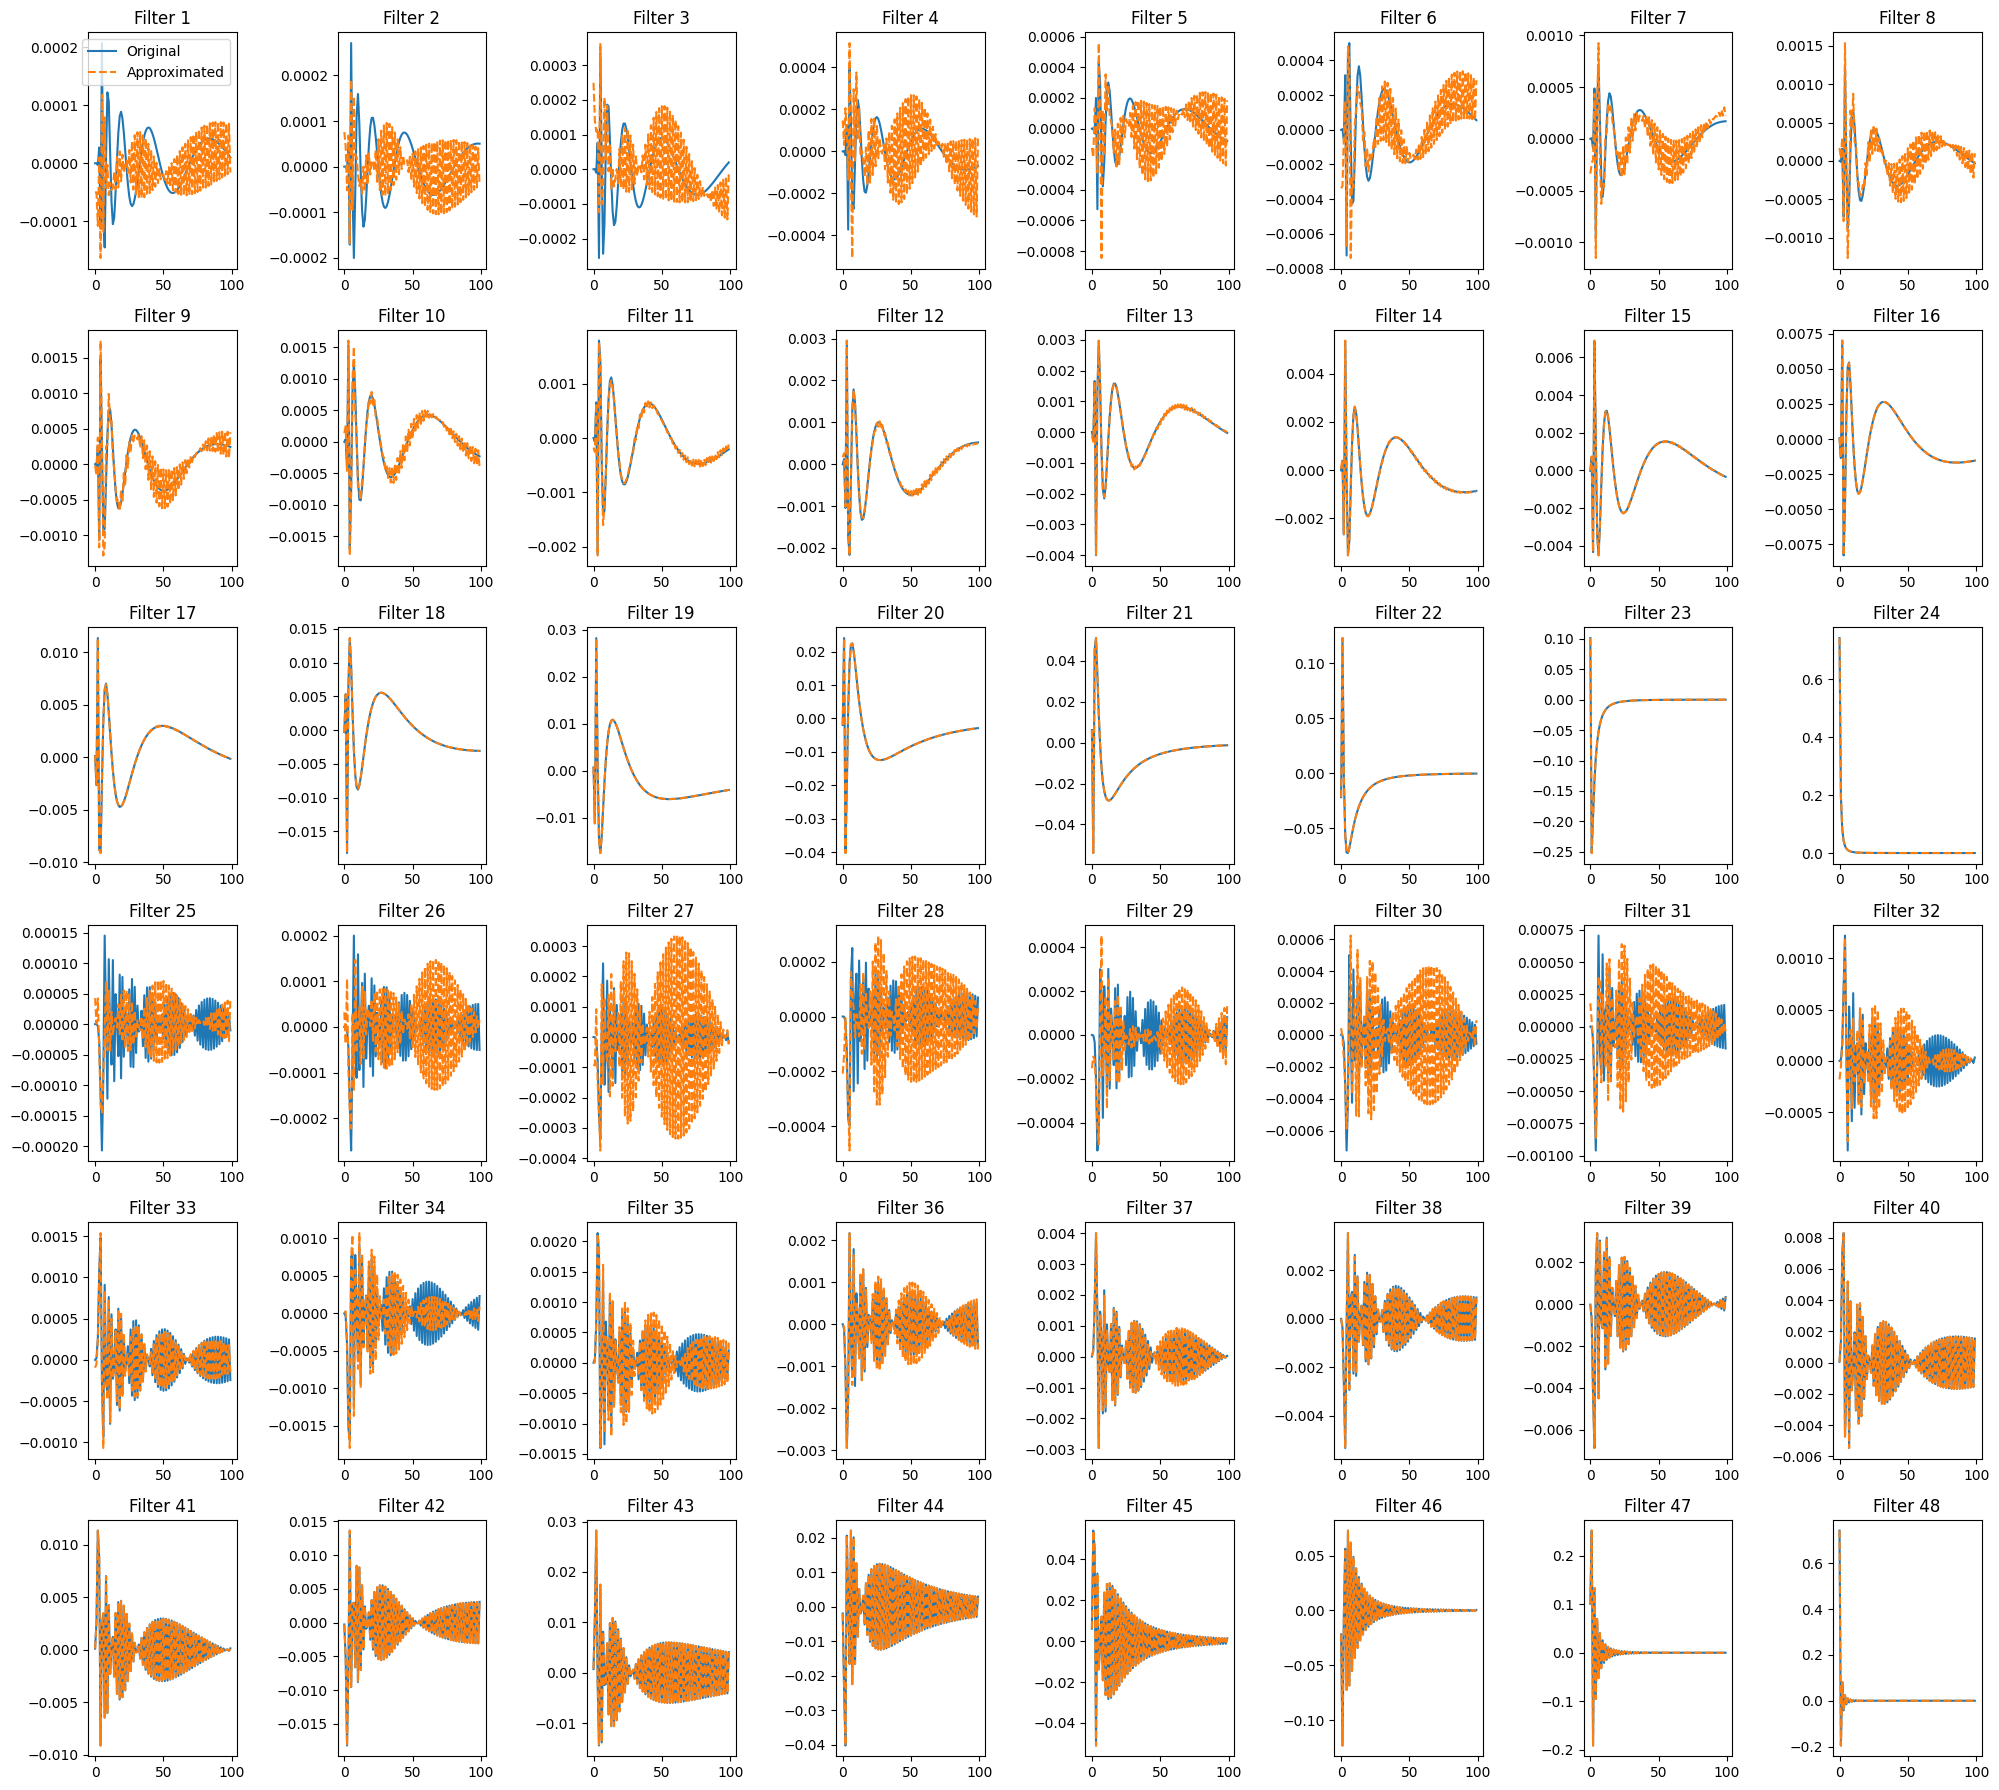

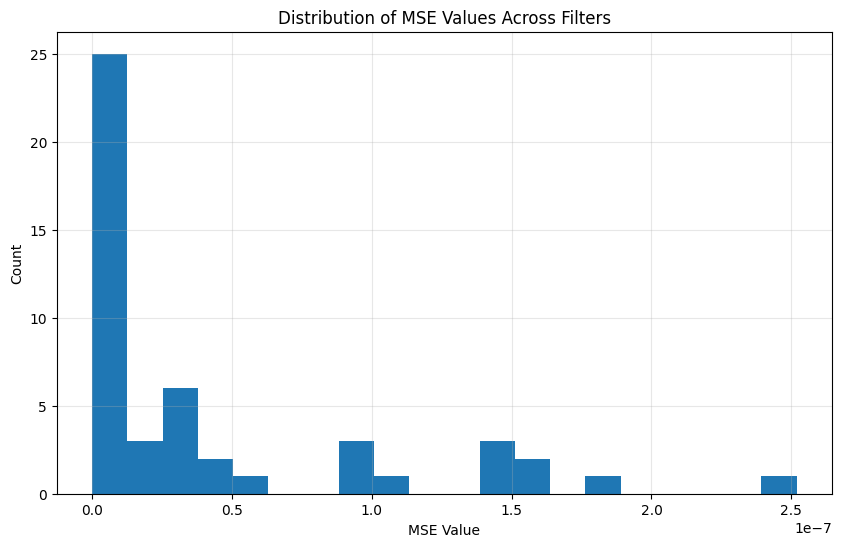

Mean MSE across filters: 4.25e-08
Median MSE across filters: 1.09e-08
Min MSE: 5.90e-12, Max MSE: 2.52e-07


In [77]:
# Plot all 48 filters to compare original vs approximated phi
num_filters = phi_n_combined.shape[1]  # Should be 48 based on previous output
num_rows = (num_filters + 7) // 8  # Arrange in 8 columns

plt.figure(figsize=(20, num_rows * 3))

for i in range(num_filters):
    plt.subplot(num_rows, 8, i + 1)
    plt.plot(phi_n_combined[:100, i], label='Original')
    plt.plot(phi_n_approx[:100, i], '--', label='Approximated')
    plt.title(f'Filter {i+1}')
    if i == 0:  # Only show legend on the first plot to avoid clutter
        plt.legend()

plt.tight_layout()
plt.show()

# Calculate MSE for each filter individually
filter_mses = []
for i in range(num_filters):
    filter_mse = F.mse_loss(
        torch.tensor(phi_n_combined[:, i]), 
        torch.tensor(phi_n_approx[:, i])
    )
    filter_mses.append(filter_mse.item())

# Plot histogram of per-filter MSE values
plt.figure(figsize=(10, 6))
plt.hist(filter_mses, bins=20)
plt.xlabel('MSE Value')
plt.ylabel('Count')
plt.title('Distribution of MSE Values Across Filters')
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print(f"Mean MSE across filters: {np.mean(filter_mses):.2e}")
print(f"Median MSE across filters: {np.median(filter_mses):.2e}")
print(f"Min MSE: {np.min(filter_mses):.2e}, Max MSE: {np.max(filter_mses):.2e}")


In [ ]:
# Perform gradient descent to improve the reconstruction
print("Starting gradient descent optimization...")

# Convert to PyTorch tensors
phi_n_combined_tensor = torch.tensor(phi_n_combined, dtype=torch.float32)
combined_weights_pinv_tensor = torch.tensor(combined_weights_pinv, dtype=torch.float32, requires_grad=True)
lds_impulses_tensor = torch.tensor(lds_impulses)

# Initialize optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam([combined_weights_pinv_tensor], lr=learning_rate)

# Training parameters
num_steps = 5e6
print_interval = 5000

# Training loop
losses = []
for step in range(num_steps + 1):
    # Forward pass: compute approximated phi
    phi_n_approx_tensor = torch.matmul(lds_impulses_tensor.T, combined_weights_pinv_tensor)
    
    # Compute loss
    loss = F.mse_loss(phi_n_approx_tensor, phi_n_combined_tensor)
    
    # Store loss
    losses.append(loss.item())
    
    # Print progress
    if step % print_interval == 0:
        print(f"Step {step}/{num_steps}, Loss: {loss.item():.2e}")
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Get the optimized weights
optimized_weights = combined_weights_pinv_tensor.detach().numpy()

# Compute the improved approximation
phi_n_improved = lds_impulses_tensor.T @ optimized_weights

# Calculate MSE between original and improved approximation
improved_mse = F.mse_loss(
    torch.tensor(phi_n_combined), 
    torch.tensor(phi_n_improved)
).item()

print(f"MSE after optimization: {improved_mse:.2e}")
print(f"Improvement factor: {mse / improved_mse:.2f}x")

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Optimization Step')
plt.ylabel('MSE Loss')
plt.title('Loss During Optimization')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

# Plot comparison of filters before and after optimization
plt.figure(figsize=(20, num_rows * 3))

for i in range(num_filters):
    plt.subplot(num_rows, 8, i + 1)
    plt.plot(phi_n_combined[:100, i], label='Original')
    plt.plot(phi_n_improved[:100, i], '--', label='Optimized')
    plt.title(f'Filter {i+1}')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# Calculate per-filter MSE for the improved approximation
improved_filter_mses = []
for i in range(num_filters):
    filter_mse = F.mse_loss(
        torch.tensor(phi_n_combined[:, i]), 
        torch.tensor(phi_n_improved[:, i])
    )
    improved_filter_mses.append(filter_mse.item())

# Plot histogram comparing MSE before and after optimization
plt.figure(figsize=(10, 6))
plt.hist(filter_mses, bins=20, alpha=0.5, label='Before Optimization')
plt.hist(improved_filter_mses, bins=20, alpha=0.5, label='After Optimization')
plt.xlabel('MSE Value')
plt.ylabel('Count')
plt.title('Distribution of MSE Values Across Filters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Starting gradient descent optimization...
Step 0/5000000, Loss: 4.25e-08
Step 5000/5000000, Loss: 4.34e-09
Step 10000/5000000, Loss: 2.67e-09
Step 15000/5000000, Loss: 2.08e-09
Step 20000/5000000, Loss: 1.75e-09
Step 25000/5000000, Loss: 1.53e-09
Step 30000/5000000, Loss: 1.38e-09
Step 35000/5000000, Loss: 1.27e-09
Step 40000/5000000, Loss: 1.18e-09
Step 45000/5000000, Loss: 1.10e-09
Step 50000/5000000, Loss: 1.04e-09
Step 55000/5000000, Loss: 9.88e-10
Step 60000/5000000, Loss: 9.42e-10
Step 65000/5000000, Loss: 9.02e-10
Step 70000/5000000, Loss: 8.67e-10
Step 75000/5000000, Loss: 8.35e-10
Step 80000/5000000, Loss: 8.06e-10
Step 85000/5000000, Loss: 7.80e-10
Step 90000/5000000, Loss: 7.56e-10
Step 95000/5000000, Loss: 7.34e-10
Step 100000/5000000, Loss: 7.14e-10
Step 105000/5000000, Loss: 6.95e-10
Step 110000/5000000, Loss: 6.78e-10
Step 115000/5000000, Loss: 6.61e-10
Step 120000/5000000, Loss: 6.46e-10
Step 125000/5000000, Loss: 6.32e-10
Step 130000/5000000, Loss: 6.18e-10
Step 135000

In [ ]:
###IS THERE AN ARGUMENT TO ONLY FIT THE TOP 24 filters (we can just make the lambda negative)